

### TASKS
1. Data cleaning and preparation
2. Explorative analysis
    - Visuals -> hist, plot, heatmap mby?
    - Descriptive statistics -> mean, median, std deviation, freq counts 
    - Figuring out which measures are important
    - Recognizing patternd and special groups etc.
    - Few hypotheses -> relations, group behaviour etc.
3. Statistical Analysis
    - Do testing -> T-test, chi-square, ANOVA jne.
    - Confidence intervals and Estimation about parameter(s) that best represent the population
    - Regression and modeling
    - Hyphothese and its testing
4. Must do a statistical model

### Reviewing criteria
1. Data preparation DONE
2. Use of descriptive statistics -> Working ON
3. Use of estimation and statistical test -> NEXT UP
4. Argumentation for design choices -> Working ON 
5. interpretation of results

### Tasks from the hypothetical scheme
1. Characterise the individuals that are present in the data. Are there groups of similar persons?
    - Distributions for all categorical values DONE
    - Find out if certain age, sex, and municipality groups have similiar activities ALMOST DONE
2. Estimate how much time on average households spend daily on each activity.
    - try out mean and medians for activities
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?
5. Which activities are associated with each other?

## Use of AI

1. Explanatory summaries of topics where I quite not understand what is the meaning of a certain statistical test where lecture slides did not answer arising questions. 
2. I have GitHub Copilot purchased by my employer. In the project I only used the code suggestions (works similiarly to snippets), that helps with repetative code and faster typing. I did NOT use the generative prompt tool. I have also found in my previous work that prompting often causes a lot of work in form of rewriting code, so I tend not to use it anyway.  
3. Some occasions I asked explanations from ChatGPT about ie. pd.dataframe syntax, since it is sometimes a bit confusing.

# Project work

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as S

import statsmodels.formula.api as SFA
import statsmodels.api as SA
import statsmodels.stats as SS
import statsmodels.stats.multitest as SSM

plt.style.use('ggplot') # found from online tutorial
# import seaborn as sns



### Data types

#### Demographic variables
- kohde - household ID: nominal
- jasen - member ID (within household): nominal
- pvknro - day of week: categorical, nominal and binary
- sp - sex: categorical, nominal and binary
- IKAL1 - age group: categorical, ordinal
- ASALUE - living environment: categorical, nominal


#### Activity variables
Time spent on activities (measured in minutes): Quantitative, ratio
- V1 - working: ratio
- V5 - cooking: ratio
- V21 - childcare: ratio
- V22 - reading and playing with children: ratio

Place visited in past 12 months 
- Values: Categorical, indicator, binary
    - 1 = yes
    - 2 = no

- H1a_A - cinema: indicator
- H1b_A - theater: indicator


## 1. Data preparation

At first glance NaN-values will be dropped, but may change over the study if effect on results seem good either way. 

At first I thought of filling zero values with mean or medians but they would heavily influence the results pushing up correlation and other metrics. It seems that particioners have deliberatley chosen 0 minutes and therefore they are not active on these metrics at all. This must be included in the results.

### Importing, renaming, description

In [63]:
df = pd.read_csv('./habits.data',
                sep=";",
                na_values=["?"],
                index_col=False,
                header=0)

In [64]:
# Keep relevant columns
columns_to_keep = ['kohde', 
                   'jasen', 
                   'pvknro', 
                   'sp', 
                   'IKAL1', 
                   'ASALUE', 
                   'V1', 
                   'V21', 
                   'V22', 
                   'V5', 
                   'H1a_A', 
                   'H1b_A']
df = df[columns_to_keep].copy()
# df

In [65]:
# Renaming columns
df.rename(columns={'kohde': 'household_id', 
                   'jasen': 'member_id', 
                   'pvknro': 'day_of_week', 
                   'sp': 'sex', 
                   'IKAL1': 'age_group', 
                   'ASALUE': 'area', 
                   'V1': 't_working', 
                   'V21': 't_cooking', 
                   'V22': 't_childcare', 
                   'V5': 't_w_child', 
                   'H1a_A': 'v_cinema', 
                   'H1b_A': 'v_theatre'
                   }, inplace=True)

In [66]:
df.loc[df['household_id'] == 51136]

,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_cooking,t_childcare,t_w_child,v_cinema,v_theatre
403,51136,2,1,2,5,1.0,0,0,0,10,NaN,NaN
404,51136,2,2,2,5,1.0,1050,0,0,0,NaN,NaN


In [67]:
print(df.info(), "\n\n")
print(df.describe().round(2), "\n\n")
print(df.isna().sum(),"\n\n")
print(df.nunique(), "\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   household_id  745 non-null    int64  
 1   member_id     745 non-null    int64  
 2   day_of_week   745 non-null    int64  
 3   sex           745 non-null    int64  
 4   age_group     745 non-null    int64  
 5   area          745 non-null    float64
 6   t_working     734 non-null    object 
 7   t_cooking     739 non-null    object 
 8   t_childcare   738 non-null    object 
 9   t_w_child     740 non-null    object 
 10  v_cinema      701 non-null    float64
 11  v_theatre     701 non-null    float64
dtypes: float64(3), int64(5), object(4)
memory usage: 70.0+ KB
None 


       household_id  member_id  day_of_week     sex  age_group    area  \
count        745.00     745.00       745.00  745.00     745.00  745.00   
mean       51016.84       1.36         1.49    1.52       6.10    1.58   


#### Notes from initial data check

- 338 unique household IDs
- Other categorical values have all categories stated in data info
- In non-categoric values there is lots of NaN values. 
- Not taking NaNs in to account the data uniqueness seems ok. 
- At least the lower 25% has 0 minutes in all activities
- Dtypes are not correct


### Cleaning erroneous values
Bad values to nan and dropped

In [68]:
# df[['v_cinema', 'v_theatre']].value_counts() --> Shows bad values

# 'v_cinema' and 'v_theatre' has NaN values and other erroneous values
# Change errenoeus to NaN and then delete all rows containing NaN values

df['v_cinema'] = df['v_cinema'].apply(lambda x: 'Yes' if x == 1.0 else 'No' if x == 2.0 else np.nan)
df['v_theatre'] = df['v_theatre'].apply(lambda x: 'Yes' if x == 1.0 else 'No' if x == 2.0 else np.nan)
df.dropna(subset=['v_cinema', 'v_theatre'], inplace=True)

print(df.isna().sum())


household_id    0
member_id       0
day_of_week     0
sex             0
age_group       0
area            0
t_working       9
t_cooking       6
t_childcare     7
t_w_child       4
v_cinema        0
v_theatre       0
dtype: int64


There is some values formatted '00:00' as str. It is hard to know if they are miss typed or spelled since other values are in minutes but these appear to be in hours. is 01:10 meant to be 110 minutes or 1h10min. Therefore dropping them out of the data.

In [69]:
columns_to_clean = ['t_working','t_cooking', 't_childcare', 't_w_child']
for column in columns_to_clean:
    df[column] = df[column].apply(
        lambda x: pd.to_numeric(x, errors='coerce')  # Convert to numeric, set invalid to NaN
    )
    df[column] = df[column].fillna(0).astype(int)  # Replace NaN with 0 before conversion

After handling bad quality data, there is 23 households with that have answered only for weekend or workday. Dropping them so all data has corresponding data for weekend and workday.

In [70]:
# Testing if there are more than 2 answers per household
one = (df['household_id'].value_counts().copy() == 1).sum()
two = (df['household_id'].value_counts().copy() == 2).sum()
over_two = (df['household_id'].value_counts().copy() > 2).sum()

print("One: {}, Two: {}, Over Two: {}".format(one, two, over_two))

occurrences = df['household_id'].value_counts().copy()
household_ids = occurrences[occurrences == 1].index

# Dropping households with only 1 answer
df = df[~df['household_id'].isin(household_ids)].copy()
print("Lines deleted")

One: 23, Two: 326, Over Two: 0
Lines deleted


### Retyping data
Types corrected and should be OK

In [71]:
# Retyping columns
df['household_id'] = df['household_id'].astype('int64')                 # Quantitative, discrete
df['member_id'] = pd.Categorical(df['member_id'])                       # Categorical, binary
df['day_of_week'] = pd.Categorical(df['day_of_week'])                   # Categorical, binary
df['sex'] = pd.Categorical(df['sex'])                                   # Categorical, binary
df['age_group'] = pd.Categorical(df['age_group'], ordered=True)         # Categorical, ordinal 
df['area'] = pd.Categorical(df['area'])                                 # Categorical, nominal

# Categorical, nominal, Int values measuring minutes
df['t_working'] = df['t_working'].astype('int64')
df['t_cooking'] = df['t_cooking'].astype('int64')
df['t_childcare'] = df['t_childcare'].astype('int64')
df['t_w_child'] = df['t_w_child'].astype('int64')

# Categorical, binary, indicator
df['v_cinema'] = pd.Categorical(df['v_cinema'])
df['v_theatre'] = pd.Categorical(df['v_theatre'])

df.dtypes


# Deleting NaN values or replacing with 0 -> if replaced, may introduce bias towards not going. 


household_id       int64
member_id       category
day_of_week     category
sex             category
age_group       category
area            category
t_working          int64
t_cooking          int64
t_childcare        int64
t_w_child          int64
v_cinema        category
v_theatre       category
dtype: object

#### Values to human readable format

In [72]:
df['day_of_week'] = df['day_of_week'].replace({1: 'workday', 2: 'weekend'})
df['sex'] = df['sex'].replace({1: 'male', 2: 'female'})
df['area'] = df['area'].replace({1: 'city', 2: 'municipality', 3: 'rural'})
df['age_group'] = df['age_group'].replace({
    1: "10-14",
    2: "15-19",
    3: "20-24",
    4: "25-34",
    5: "35-44",
    6: "45-54",
    7: "55-64",
    8: "65-74",
    9: "75+"
})
# Warnings of deprecated function but works

C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\689488908.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['day_of_week'] = df['day_of_week'].replace({1: 'workday', 2: 'weekend'})
C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\689488908.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['sex'] = df['sex'].replace({1: 'male', 2: 'female'})
C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\689488908.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be us

In [73]:
# Checking ID values for anomalies
print('ID max:', df.household_id.max())
print('ID min:', df.household_id.min())
print("Unique ID's:", df.household_id.nunique())

# Looks OK
# Few household_ids are missing since we deleted some rows and did not re_index++# Time spent in activities
# Check weekend and workday separately


ID max: 51983
ID min: 50002
Unique ID's: 326


## 2. Explorative analysis
Descriptive plots done and some conlusions made already. Some "non-trivial" groups found. Means and medians calculated. Frequencies maybe still needed for categorical values.

    - Visuals -> hist, plot, heatmap mby?
    - Descriptive statistics -> mean, median, std deviation, freq counts 
    - Figuring out which measures are important
    - Recognizing patternd and special groups etc.
    - Few hypotheses -> relations, group behaviour etc.

In [74]:
# If I want to see only males -> select Day_of_Week[Workday OR workday] AND Sex[Male OR Female]
female_workday = df[(df['day_of_week'] == 'workday') & (df['sex'] == 'female')].sort_values('age_group')
female_weekend = df[(df['day_of_week'] == 'weekend') & (df['sex'] == 'female')].sort_values('age_group')
male_workday = df[(df['day_of_week'] == 'workday') & (df['sex'] == 'male')].sort_values('age_group')
male_weekend = df[(df['day_of_week'] == 'weekend') & (df['sex'] == 'male')].sort_values('age_group')

# Histogram maybe not so good
# male_weekend['t_working'].plot.hist(bins=20, xlabel='Minutes')
# male_workday['t_working'].plot.hist(bins=20, xlabel='Minutes')
# female_weekend['t_working'].plot.hist(bins=20, xlabel='Minutes')
# female_workday['t_working'].plot.hist(bins=20, xlabel='Minutes')

### Questions that arises?

- Group differences
    - Working
    - Not working
    - Different age groups
    - Men and Women

- Member ID seems quite irreleveant, unless there is significant behaviour change in them

### 2.1 Visuals and plotting

<Axes: xlabel='v_cinema,v_theatre'>

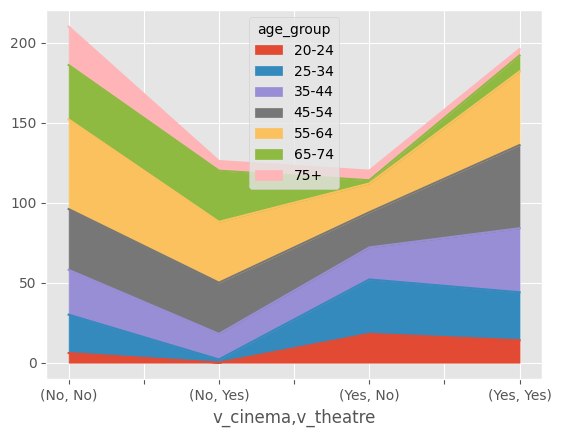

In [75]:
df.groupby('age_group', observed=False)[['v_cinema', 'v_theatre']].value_counts().unstack('age_group').plot.area(stacked=True)



- Older people visit less culture events, especially less cinema but prefer only theartre or both but not only cinema.
- 35 - 74 years old's go more theatre than other 75+ and 20-24 yrs olds.
- Overall trend is that people either go to both or neither. 
- Much less people go to only one of the activities

<Axes: xlabel='v_cinema,v_theatre'>

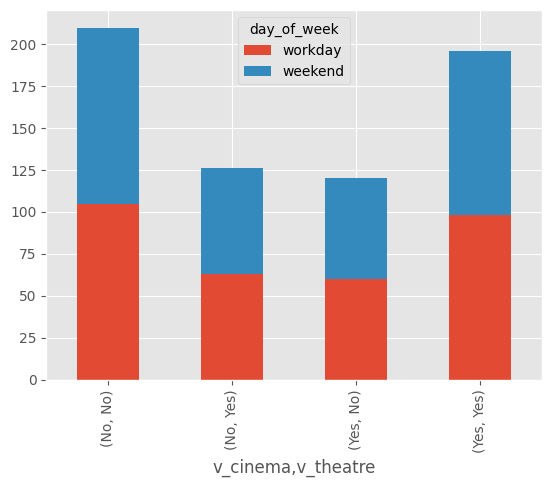

In [76]:
df.groupby('day_of_week', observed=False)[['v_cinema', 'v_theatre']].value_counts().unstack('day_of_week').plot.bar(stacked=True)

- ~20% dont go to cinema but goes to theatre 
- ~19% go to cinema but doesn't go to theatre
- ~33,5% does not go to either
- ~31% goes to both cinema and theatre
- There is no or low difference whether it is workday or weekend on the whole population

In [77]:
# Chekcing rows where no time spent on any activity
time_columns = ['t_working', 't_cooking', 't_childcare', 't_w_child']
time_df = df[time_columns]
ids = df.loc[time_df[time_columns].sum(axis=1) == 0].household_id.value_counts()
print("Sum of id's with 0 minutes in all 4 fields:", len(ids))

ids = ids[ids > 1].index
print("Sum of id's where both weekend and workday activities 0 minutes:", len(ids))
ids

df_no_activity = df[(df['household_id'].isin(ids)) & (df['v_cinema'] == 'No') & (df['v_theatre'] == 'No') ]

print("Sum of id's that do none of the acts in any day:", int(len(df_no_activity) / 2)) # Amount of individuals that do none of the activities any day

Sum of id's with 0 minutes in all 4 fields: 111
Sum of id's where both weekend and workday activities 0 minutes: 53
Sum of id's that do none of the acts in any day: 18


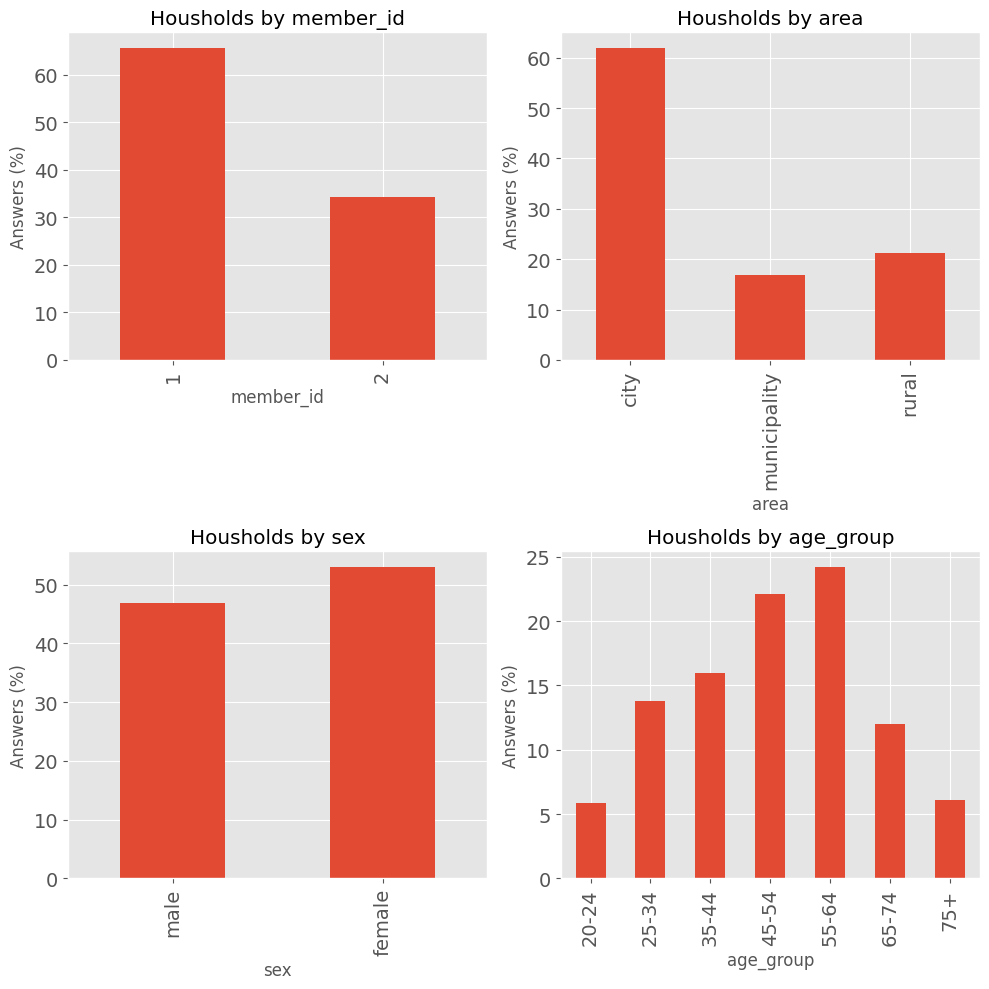

In [78]:
# Trying to create subplots with a loop
#  Age distributions in relation to sex, area are interesting 
demographics = ['member_id', 'area', 'sex', 'age_group']

columns = len(demographics)
rows = int(columns / 2)
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, 5 * rows))
axes = axes.flatten()

# Previous method axes.flatten() creates a list to iterate over with a single digit
# Subplots for each column with demogrpaphic types
for i, column in enumerate(demographics):
    counts = df.groupby([column], observed=False)['household_id'].nunique()
    percent = (counts / counts.sum()) * 100
    percent.plot.bar(ax=axes[i], fontsize=14)
    axes[i].set_title(f'Housholds by {column}')
    axes[i].set_ylabel('Answers (%)')
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()

# Density plots ???

# df[df['sex'] == 'female'].groupby(['age_group', 'area']).size().unstack().plot(xlabel='female', kind='bar', ax=axes[1], stacked=True)


                        household_id
age_group area                      
20-24     city                     8
          municipality             1
25-34     city                     8
          rural                    3
35-44     city                    14
          municipality             6
          rural                    3
45-54     city                    24
          municipality             6
          rural                    9
55-64     city                    23
          municipality             8
          rural                   10
65-74     city                    13
          municipality             2
          rural                    5
75+       city                     4
          municipality             3
          rural                    3


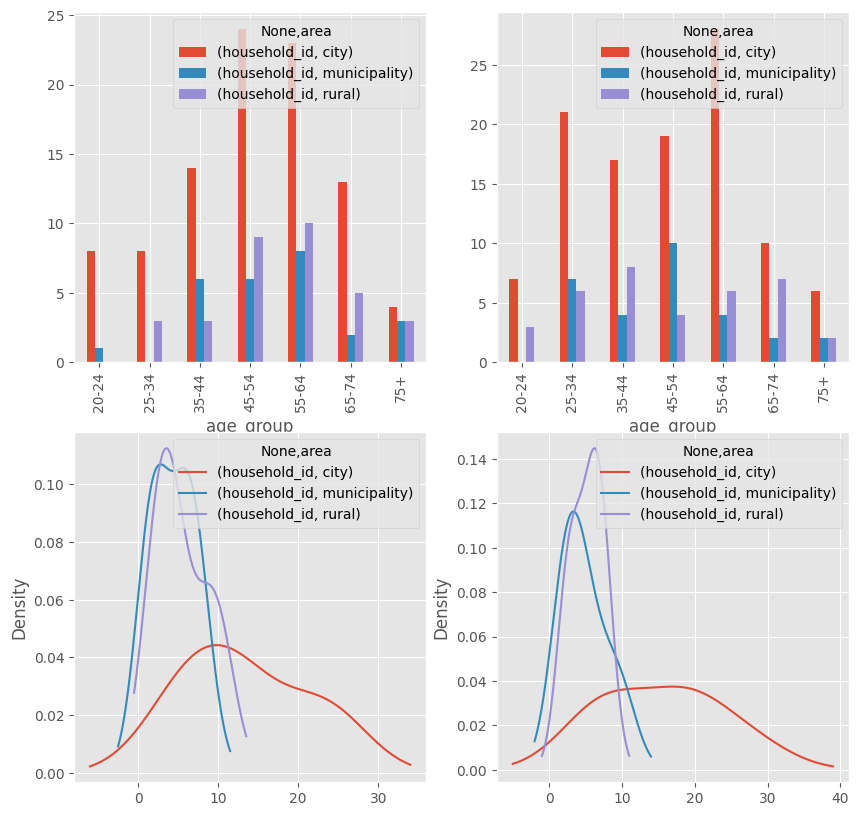

In [79]:
# Creating subplots individually
# Calculated in respect to individual households ~336

# mean values for men and women living in different areas
df_male = df[df['sex'] == 'male'][['household_id','age_group','area']].groupby(['age_group','area'], observed=True).nunique()
df_female = df[df['sex'] == 'female'][['household_id','age_group','area']].groupby(['age_group', 'area'], observed=True).nunique()

fig, axes = plt.subplots(nrows=2, 
                         ncols=2, 
                         figsize=(10, 10))

df_male.unstack('area').plot(kind='bar', ax=axes[0,0])
df_male.unstack('area').plot(kind='density', ax=axes[1,0])
df_female.unstack('area').plot(kind='bar', ax=axes[0,1])
df_female.unstack('area').plot(kind='density', ax=axes[1,1])

print(df_male)




Observed = True shows: 
- that there is no younger age_groups in Male population in areas of municipality and rural
- And female population in municipality also lacks answerers

[Text(0.5, 0, 'Female')]

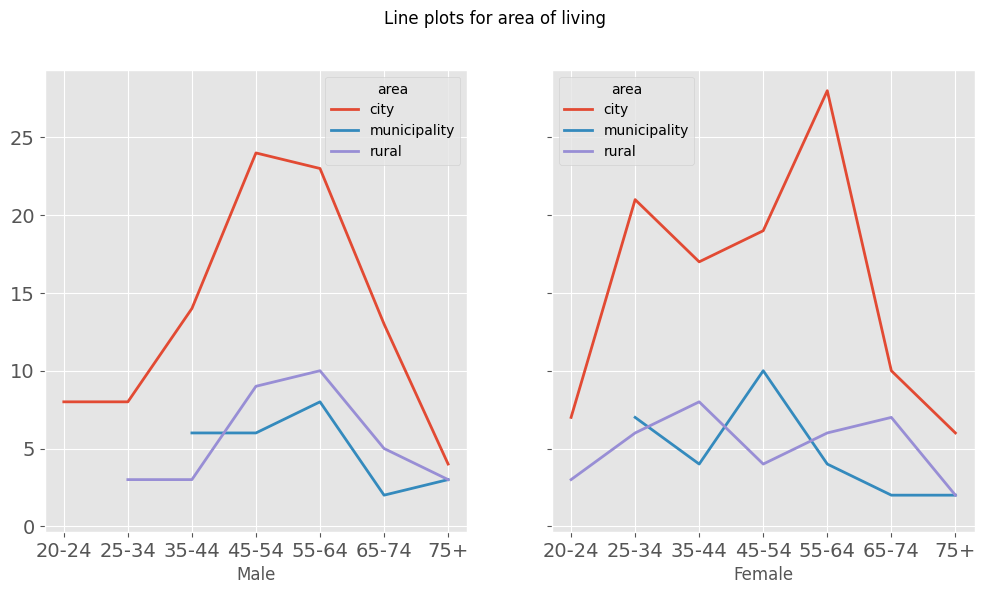

In [80]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         sharey=True, 
                         sharex=True, 
                         figsize=(12, 6),
                         )

# For area duplicates are not needed
unique_df = df.drop_duplicates(subset='household_id', keep='first')
unique_df

unique_df[unique_df['sex'] == 'male'].groupby(['age_group', 'area'], observed=True).size().unstack('area').plot(kind='line', ax=axes[0], fontsize=14, linewidth=2)
unique_df[unique_df['sex'] == 'female'].groupby(['age_group', 'area'], observed=True).size().unstack('area').plot(kind='line', ax=axes[1], fontsize=14, linewidth=2)

fig.suptitle('Line plots for area of living')
axes[0].set(xlabel='Male')
axes[1].set(xlabel='Female')

In [81]:
sex_sums = df[['sex']].value_counts()
ratio = sex_sums.female.sum() / sex_sums.male.sum()
ratio
# There is {ratio} times more female than men overall

1.130718954248366

### 2.2 Numerical variables measuring time
mean median std deviation and frequencies



#### Percentages for people spending time on activities

In [82]:
list = ['t_working', 't_cooking', 't_childcare', 't_w_child']
df_weekend = df[df['day_of_week'] == 'weekend']
df_workday = df[df['day_of_week'] == 'workday']

weekend_percent = pd.DataFrame(
    columns=['Weekend %'],
    index=['t_working', 't_cooking', 't_childcare', 't_w_child']
)

workday_percent = pd.DataFrame(
    columns=['Workday %'],
    index=['t_working', 't_cooking', 't_childcare', 't_w_child']
)
for column in list:
    weekend_percent.loc[column] = len(df_workday[column].replace(0, pd.NA).dropna()) / len(df_weekend[column]) * 100

for column in list:
    workday_percent.loc[column] = len(df_weekend[column].replace(0, pd.NA).dropna()) / len(df_workday[column]) * 100

weekend_percent, workday_percent    

# working_percent = len(df[df['t_working'] != 0]) / len(df[df['t_working'] == 0])
# print("Working percent:", round(working_percent, 3))


(             Weekend %
 t_working    27.300613
 t_cooking    11.349693
 t_childcare   5.521472
 t_w_child    66.564417,
              Workday %
 t_working    25.460123
 t_cooking     11.96319
 t_childcare   6.748466
 t_w_child    63.803681)

#### Mean, Median and Std (Estimation)
Not taking 0's into account and only examining the population that are spending time. 


In [83]:
list = ['t_working', 't_cooking', 't_childcare', 't_w_child']
df_workday = df[df['day_of_week'] == 'workday']
mean = df_workday[list].replace(0, pd.NA).mean()  # Replace 0 with NaN if you want to ignore zero values
median = df_workday[list].replace(0, pd.NA).median()
std = df_workday[list].replace(0, pd.NA).std()

workday_stats = pd.DataFrame({
    'Mean': mean,
    'Median': median,
    'Standard Deviation': std
}).round(2)

df_weekend = df[df['day_of_week'] == 'weekend']
mean = df_weekend[list].replace(0, pd.NA).mean()  # Replace 0 with NaN if you want to ignore zero values
median = df_weekend[list].replace(0, pd.NA).median()
std = df_weekend[list].replace(0, pd.NA).std()

weekend_stats = pd.DataFrame({
    'Mean': mean,
    'Median': median,
    'Standard Deviation': std
}).round(2)

workday_stats, weekend_stats

(                  Mean Median Standard Deviation
 t_working    412.58427  440.0         162.561374
 t_cooking    88.378378   50.0          95.728595
 t_childcare  64.444444   50.0          42.318432
 t_w_child    44.101382   30.0          34.897321,
                    Mean Median Standard Deviation
 t_working    402.289157  440.0         172.459435
 t_cooking     88.717949   60.0          98.999721
 t_childcare   73.636364   45.0          86.219292
 t_w_child         46.25   40.0          32.857105)

#### Means and deviations for whole population

In [84]:
list = ['t_working', 't_cooking', 't_childcare', 't_w_child']
# print(df['day_of_week' == 'workday'][list].std())
workday_mean = df[df['day_of_week'] == 'workday'][list].mean()
weekend_mean = df[df['day_of_week'] == 'weekend'][list].mean()

workday_std = df[df['day_of_week'] == 'workday'][list].std()
weekend_std = df[df['day_of_week'] == 'weekend'][list].std()

deviations = pd.concat([workday_mean, weekend_mean, workday_std, weekend_std], axis=1, keys=['workday mean', 'weekend mean', 'workday Std', 'Weekend Std']).round(2)
deviations
# deviations.plot(kind='scatter')


,workday mean,weekend mean,workday Std,Weekend Std
t_working,112.64,102.42,202.59,195.73
t_cooking,10.03,10.61,42.47,44.47
t_childcare,3.56,4.97,17.63,28.68
t_w_child,29.36,29.51,35.26,34.40


#### Grouped by sex

In [85]:
list = ['sex','t_working', 't_cooking', 't_childcare', 't_w_child']
workday_mean = df[df['day_of_week'] == 'workday'][list].groupby('sex', observed=False).mean()
pd.concat([workday_mean], axis=1, keys=['workday mean']).round(2)

workday mean                                
          t_working t_cooking t_childcare t_w_child
sex                                                
male         111.24      3.73        0.85     20.46
female       113.87     15.61        5.95     37.23

In [86]:
list = ['sex','t_working', 't_cooking', 't_childcare', 't_w_child']
weekend_mean = df[df['day_of_week'] == 'weekend'][list].groupby('sex', observed=False).mean()
pd.concat([weekend_mean], axis=1, keys=['Weekend mean']).round(2)

Weekend mean                                
          t_working t_cooking t_childcare t_w_child
sex                                                
male         104.31      2.88        2.42     17.71
female       100.75     17.46        7.23     39.94

#### Grouped by age_group

In [87]:
list = ['age_group','t_working', 't_cooking', 't_childcare', 't_w_child']
workday_mean = df[df['day_of_week'] == 'workday'][list].groupby('age_group', observed=False).mean()
pd.concat([workday_mean], axis=1, keys=['workday mean']).round(2)

workday mean                                
             t_working t_cooking t_childcare t_w_child
age_group                                             
20-24           123.68      2.63        2.63     16.84
25-34           129.56     32.00       11.56     19.78
35-44           170.00     27.69        9.23     31.35
45-54           178.75      4.44        1.53     29.58
55-64            78.99      0.25        0.00     33.92
65-74            15.13      0.00        0.00     29.74
75+               0.00      0.00        0.00     38.00

In [88]:
weekend_mean = df[df['day_of_week'] == 'weekend'][list].groupby('age_group', observed=False).mean()
pd.concat([weekend_mean], axis=1, keys=['Weekend mean']).round(2)

Weekend mean                                
             t_working t_cooking t_childcare t_w_child
age_group                                             
20-24            95.79      1.05        5.79     10.00
25-34            90.67     43.56       21.56     19.11
35-44           178.27     24.81        9.04     33.27
45-54           194.44      2.64        0.97     25.69
55-64            48.48      0.00        0.00     34.05
65-74             8.46      0.00        0.00     38.72
75+               3.00      0.00        0.00     39.50

#### Grouped by area

In [89]:
list = ['area','t_working', 't_cooking', 't_childcare', 't_w_child']
workday_mean = df[df['day_of_week'] == 'workday'][list].groupby('area', observed=False).mean()
pd.concat([workday_mean], axis=1, keys=['workday mean']).round(2)

workday mean                                
                t_working t_cooking t_childcare t_w_child
area                                                     
city                99.26      7.38        3.61     29.90
municipality       154.73     20.91        6.73     32.36
rural              118.26      9.13        0.87     25.36

In [90]:
weekend_mean = df[df['day_of_week'] == 'weekend'][list].groupby('area', observed=False).mean()
pd.concat([weekend_mean], axis=1, keys=['Weekend mean']).round(2)

Weekend mean                                
                t_working t_cooking t_childcare t_w_child
area                                                     
city               102.67      9.85        3.47     28.71
municipality       105.64     20.00       12.00     29.27
rural               99.13      5.36        3.77     32.03

- T_working, std deviation indicates high difference in working time values because mean is only less than 2 hours

- Same gous through out the data. It seems time spent on these activities are quite low on average with respectively high deviation, that indicates that most of whom spend time on these activities spend significantly more than the average and many people do not spend time at all or very little

- I there is groups that are employed and unemployed. Groups that have childern or grandchildren or live at home, therefore spending time on childcare and act_w_child. 

- Means and deviations with groups age, sex and municipality should be done to observe more.

### 2.3 Categorical variables characteristics

173


[Text(0, 0, 'city'), Text(1, 0, 'municipality'), Text(2, 0, 'rural')]

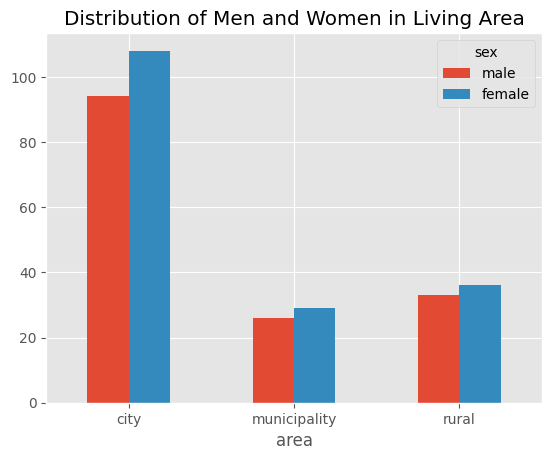

In [91]:
# Living area distribution
counts = df['area'].value_counts().copy()

women_count = (df.drop_duplicates(subset='household_id')['sex'] == 'female').sum()
print(women_count)
area_sex_counts = df.groupby(['area', 'sex'], observed=False).size().unstack().copy()
axis3 = (area_sex_counts / 2).plot(kind='bar', title='Distribution of Men and Women in Living Area')
axis3.set_xticklabels(axis3.get_xticklabels(), rotation=0)

In [92]:
# Filter the dataframe to include only rows where Day_of_Week is 1
df_workday = df[df['day_of_week'] == 2].copy()

# Convert to numeric
df_scatter_workday = df_workday.apply(pd.to_numeric, errors='coerce')

# Select the columns to normalize (columns 5 to 9)
columns_to_normalize = df_scatter_workday.columns[5:10]

# Apply the rank method to normalize to percentiles
df_scatter_workday[columns_to_normalize] = df_scatter_workday[columns_to_normalize].rank(pct=True)

# Ensure 'v_theatre' is of type int64
df_scatter_workday['v_theatre'] = df_scatter_workday['v_theatre'].astype('int64')

# Plot the scatter matrix
# scatter_matrix = pd.plotting.scatter_matrix(df_scatter_workday.iloc[:, 4:10], figsize=(10, 10))


In [93]:
# Plot distributions of categorical variables
categorical_columns = ['day_of_week', 'sex', 'age_group', 'area']  # Day of week, Sex, Age, Area

### 2.4 Recognizing groups by activity

#### Answering to questions
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?

Employed and unemployed
People who go to theatre and cinema tend to live in citys
Cook a lot -> lives somewhere?

Employment percentage in citys and other areas

#### Employed and unemployed dataframes

In [94]:
employed = df[df['t_working'] > 0]
unemployed = df[df['t_working'] == 0]
employed.head()


# working = numerical['t_working']
# cooking = numerical['t_cooking']
# childcare = numerical['t_childcare']
# w_child = numerical['t_w_child']


,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_cooking,t_childcare,t_w_child,v_cinema,v_theatre
1,50002,1,weekend,male,45-54,city,380,0,0,10,No,No
4,50004,2,workday,male,55-64,city,640,0,0,0,No,Yes
18,50028,1,weekend,female,35-44,city,440,0,0,0,Yes,No
19,50030,1,workday,male,45-54,municipality,430,0,0,20,Yes,Yes
23,50034,1,workday,female,45-54,city,440,0,0,10,No,Yes


In [95]:
employed['v_cinema'] = employed['v_cinema'].map({'Yes': 1, 'No': 0}).astype(bool)
employed['v_theatre'] = employed['v_theatre'].map({'Yes': 1, 'No': 0}).astype(bool)
unemployed['v_cinema'] = unemployed['v_cinema'].map({'Yes': 1, 'No': 0}).astype(bool)
unemployed['v_theatre'] = unemployed['v_theatre'].map({'Yes': 1, 'No': 0}).astype(bool)

C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\2136140920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employed['v_cinema'] = employed['v_cinema'].map({'Yes': 1, 'No': 0}).astype(bool)
C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\2136140920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employed['v_theatre'] = employed['v_theatre'].map({'Yes': 1, 'No': 0}).astype(bool)
C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\2136140920.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

#### 2.4.1 Visited theatre and cinema

##### Visited activities //  group 'age'

TODO: Plot cinema and theatre

In [96]:
employed.groupby('age_group', observed=False)[['v_theatre', 'v_cinema']].mean()

,v_theatre,v_cinema
age_group,,
20-24,0.181818,0.636364
25-34,0.291667,0.875000
35-44,0.500000,0.523810
45-54,0.645161,0.483871
55-64,0.535714,0.500000
65-74,0.500000,0.500000
75+,1.000000,0.000000


In [97]:
unemployed.groupby('age_group', observed=False)[['v_theatre', 'v_cinema']].mean()

,v_theatre,v_cinema
age_group,,
20-24,0.444444,0.925926
25-34,0.378788,0.651515
35-44,0.564516,0.612903
45-54,0.536585,0.536585
55-64,0.530769,0.384615
65-74,0.540541,0.135135
75+,0.230769,0.256410


##### Visited activities // group 'sex'

In [98]:
employed.groupby('sex', observed=False)[['v_theatre', 'v_cinema']].mean()

,v_theatre,v_cinema
sex,,
male,0.386667,0.413333
female,0.608247,0.670103


In [99]:
unemployed.groupby('sex', observed=False)[['v_theatre', 'v_cinema']].mean()

,v_theatre,v_cinema
sex,,
male,0.463203,0.393939
female,0.510040,0.518072


#### 2.4.2 Time spent on activities 

##### Time spent // group 'sex'

In [100]:
# employed.groupby('age_group').value_counts()['t_working']
# Group by 'age_group' in the employed DataFrame
employed.groupby('sex', observed=False)[['t_working', 't_cooking', 't_childcare', 't_w_child']].mean().round(3)


,t_working,t_cooking,t_childcare,t_w_child
sex,,,,
male,439.733,4.667,0.933,18.267
female,382.784,12.990,3.299,27.938


In [101]:
unemployed.groupby('sex', observed=False)[['t_working', 't_cooking', 't_childcare', 't_w_child']].mean().round(3)


,t_working,t_cooking,t_childcare,t_w_child
sex,,,,
male,0.0,2.857,1.861,19.351
female,0.0,17.912,7.871,42.731


##### Time spent // group 'age'

In [102]:
employed.groupby('age_group', observed=False)[['t_working', 't_cooking', 't_childcare', 't_w_child']].mean().round(3)

,t_working,t_cooking,t_childcare,t_w_child
age_group,,,,
20-24,379.091,0.000,0.000,21.818
25-34,412.917,32.083,8.333,19.583
35-44,431.190,11.190,2.857,27.857
45-54,433.387,5.645,1.129,23.387
55-64,359.643,0.714,0.000,22.857
65-74,230.000,0.000,0.000,27.500
75+,60.000,0.000,0.000,0.000


In [103]:
unemployed.groupby('age_group', observed=False)[['t_working', 't_cooking', 't_childcare', 't_w_child']].mean().round(3)

,t_working,t_cooking,t_childcare,t_w_child
age_group,,,,
20-24,0.0,2.593,5.926,10.000
25-34,0.0,39.848,19.545,19.394
35-44,0.0,36.452,13.387,35.323
45-54,0.0,1.951,1.341,30.854
55-64,0.0,0.000,0.000,36.385
65-74,0.0,0.000,0.000,34.595
75+,0.0,0.000,0.000,39.744


##### Time spent // group 'area'

In [104]:
employed.groupby('area', observed=False)[['t_working', 't_cooking', 't_childcare', 't_w_child']].mean().round(3)

,t_working,t_cooking,t_childcare,t_w_child
area,,,,
city,407.900,9.100,3.000,25.000
municipality,397.778,18.611,0.556,23.056
rural,416.667,0.833,1.944,20.833


In [105]:
unemployed.groupby('area', observed=False)[['t_working', 't_cooking', 't_childcare', 't_w_child']].mean().round(3)

,t_working,t_cooking,t_childcare,t_w_child
area,,,,
city,0.0,8.454,3.717,30.724
municipality,0.0,21.351,13.649,34.595
rural,0.0,9.510,2.451,31.471


#### 2.4.3 People who are working all week

In [106]:
df_w = df[df['t_working'] > 0]
id_counts = df_w.groupby('household_id', observed=False).size()
id_two_entries = id_counts[id_counts == 2].index

df_w[df_w['household_id'].isin(id_two_entries)].copy()

,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_cooking,t_childcare,t_w_child,v_cinema,v_theatre
64,50151,1,workday,male,20-24,city,630,0,0,100,Yes,No
65,50151,1,weekend,male,20-24,city,530,0,0,20,Yes,No
76,50203,1,workday,male,35-44,rural,580,0,0,0,No,No
77,50203,1,weekend,male,35-44,rural,520,0,0,0,No,No
147,50378,1,workday,female,45-54,city,540,0,0,20,Yes,No
148,50378,1,weekend,female,45-54,city,590,10,0,70,Yes,No
186,50518,1,workday,male,45-54,rural,490,0,0,50,No,Yes
187,50518,1,weekend,male,45-54,rural,70,0,70,20,No,Yes
208,50584,2,workday,female,35-44,city,530,0,0,50,No,Yes
209,50584,2,weekend,female,35-44,city,60,0,0,40,No,Yes


In [107]:
df_wc = df[df['t_working'] > 0]
df_wc[df_wc['t_cooking'] > 0]

,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_cooking,t_childcare,t_w_child,v_cinema,v_theatre
40,50098,1,weekend,female,45-54,city,400,40,0,70,Yes,Yes
52,50120,1,weekend,female,25-34,municipality,90,190,0,70,No,No
112,50306,1,workday,female,35-44,city,400,90,30,50,No,Yes
148,50378,1,weekend,female,45-54,city,590,10,0,70,Yes,No
157,50390,1,workday,male,45-54,municipality,380,60,0,0,No,No
166,50427,1,weekend,female,35-44,city,150,70,70,70,No,Yes
228,50617,2,workday,female,25-34,municipality,360,20,0,10,Yes,No
229,50617,2,weekend,female,25-34,municipality,420,70,20,30,Yes,No
235,50640,2,weekend,male,35-44,city,530,70,0,0,Yes,Yes
274,50768,2,workday,female,35-44,rural,310,20,0,30,No,Yes


In [108]:
df_wc = df[df['t_working'] == 0]
df_wc[df_wc['t_cooking'] > 0]

,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_cooking,t_childcare,t_w_child,v_cinema,v_theatre
2,50003,1,workday,female,35-44,municipality,0,50,0,60,No,Yes
3,50003,1,weekend,female,35-44,municipality,0,50,0,50,No,Yes
8,50006,1,workday,female,25-34,municipality,0,70,90,60,No,Yes
9,50006,1,weekend,female,25-34,municipality,0,40,40,30,No,Yes
15,50020,1,workday,female,25-34,municipality,0,120,20,30,No,No
17,50028,1,workday,female,35-44,city,0,20,0,0,Yes,No
29,50059,2,workday,female,35-44,city,0,50,110,40,Yes,No
30,50059,2,weekend,female,35-44,city,0,70,130,20,Yes,No
39,50098,1,workday,female,45-54,city,0,80,0,180,Yes,Yes
51,50120,1,workday,female,25-34,municipality,0,90,0,100,No,No


In [109]:
# Calculate median for each activity, excluding zero values
household_medians_nonzero = df[df['t_working'] > 0].groupby('household_id')['t_working'].median().median(), \
                            df[df['t_cooking'] > 0].groupby('household_id')['t_cooking'].median().median(), \
                            df[df['t_childcare'] > 0].groupby('household_id')['t_childcare'].median().median(), \
                            df[df['t_w_child'] > 0].groupby('household_id')['t_w_child'].median().median()

print("Median time spent (excluding zero values):\n", household_medians_nonzero)


Median time spent (excluding zero values):
 (445.0, 50.0, 52.5, 37.5)


#### By workday and weekend

In [110]:
df_workday = df[df['day_of_week'] == 'workday']
df_weekend = df[df['day_of_week'] == 'weekend']

#### People who are not working

In [111]:
df_wc = df_workday[df_workday['t_working'] == 0]
df_wc_ck = df_wc[df_wc['t_cooking'] == 0]
df_wc.describe().round(2)

,household_id,t_working,t_cooking,t_childcare,t_w_child
count,237.00,237.0,237.00,237.00,237.00
mean,50998.10,0.0,10.76,4.77,30.84
std,604.61,0.0,46.93,20.47,37.79
min,50002.00,0.0,0.00,0.00,0.00
25%,50394.00,0.0,0.00,0.00,0.00
50%,51027.00,0.0,0.00,0.00,20.00
75%,51498.00,0.0,0.00,0.00,50.00
max,51983.00,0.0,410.00,170.00,190.00


## 3. Patterns and hypothesis

1. Characterise the individuals that are present in the data. Are there groups of similar persons?
    Trivial groups -> Age, Area, sex
    Groups via activity -> how to know??

    Not so trivial groups -> employed, unemployed, cook alot?, with children, visitin culture, not visiting culture

2. Estimate how much time on average households spend daily on each activity.
    Mean values + medians, -> Task: calculate medians

5. Which activities are associated with each other?
    Task: calculate Correlations with activities

## 4. Statistical Analysis

1. Kruskal-Wallis test for numerival variables t_activities

2. Pearsons Chi-squared test for multiple categorical values -> value_counts as occurrences

1. Difference in groups
    1. Unemployed - employed
    1. Working only 
2. Find out if activities attract certain people
3. 

### 4.1. Kruskal Wallis test  

In [112]:
# 1. t_activities


t_activities = ['t_working', 't_cooking', 't_childcare', 't_w_child']

s1 = pd.Series(unemployed['t_working'])
s2 = pd.Series(unemployed['t_cooking'])
s3 = pd.Series(unemployed['t_childcare'])
s4 = pd.Series(unemployed['t_w_child'])
df_t_activities = pd.concat([s1, s2, s3, s4], axis=1)

# small samples from non-normal distributions --> Kruskal-Wallis test
# (assuming that the numbers are measured values from 6-sided dice)

print(S.kruskal(s1, s2, s3, s4).pvalue, end="\n\n")
print("This P-value is very low probably due to all the 0 values. \nSome kind of subset data for analysing should be taken \n")

# The null hypothesis is that no group tends to have
# smaller or larger values than the others. A high p-value
# indicates that there is no evidence to claim that one
# die differs from the others.

1.1645782333013087e-156

This P-value is very low probably due to all the 0 values. 
Some kind of subset data for analysing should be taken 



### Chi-squared for categorical


In [113]:
categorical = ['age_group', 'area', 'sex']

continquency_table = pd.crosstab(df['age_group'], df['area'], margins=True)

chi2, p, dof, expected = S.chi2_contingency(continquency_table)

pd.DataFrame({
    'Chi2': [chi2],
    'P-value': [p],
    'Degrees of Freedom': [dof],
})

,Chi2,P-value,Degrees of Freedom
0,18.017975,0.647866,21


In [114]:
df_workday_time = df_workday[['t_working', 't_cooking', 't_childcare', 't_w_child']]
df_weekend_time = df_weekend[['t_working', 't_cooking', 't_childcare', 't_w_child']]
df_workday_time.describe().round(2)

,t_working,t_cooking,t_childcare,t_w_child
count,326.00,326.00,326.00,326.00
mean,112.64,10.03,3.56,29.36
std,202.59,42.47,17.63,35.26
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,20.00
75%,117.50,0.00,0.00,40.00
max,760.00,410.00,170.00,190.00


In [115]:

# pd.plotting.scatter_matrix(df_weekday_time, figsize=(20,20))
df_workday_time.corr(method='spearman')

,t_working,t_cooking,t_childcare,t_w_child
t_working,1.000000,0.059326,-0.118823,-0.022053
t_cooking,0.059326,1.000000,0.603550,0.152561
t_childcare,-0.118823,0.603550,1.000000,0.196448
t_w_child,-0.022053,0.152561,0.196448,1.000000


### 4.2. Activities
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?
5. Which activities are associated with each other?

### Mann-Whitney U-Test for Working time grouped by sex

In [116]:
# Mann whitney U Test since not normal unpaired variables
# N0: The distributions of the two groups are the same
# N1: The distributions of the two groups are different

employed_m = employed[employed['sex'] == 'male']
employed_f = employed[employed['sex'] == 'female']

s1 = pd.Series(employed_m['t_working'])
s2 = pd.Series(employed_f['t_working']) 

result_e_w = S.mannwhitneyu(s1,s2, use_continuity=True, alternative='two-sided')[1]
result_e_w
print("Result P < 0.05:", f'{result_e_w < 0.05}, P =', result_e_w.round(4))
# print(S.kruskal(s1, s2).pvalue, end="\n\n")



Result P < 0.05: True, P = 0.0118


In [117]:
# Mann whitney U Test since not normal unpaired variables
# N0: The distributions of the two groups are the same
# N1: The distributions of the two groups are different

employed_m = employed[employed['sex'] == 'male']
employed_f = employed[employed['sex'] == 'female']

s1 = pd.Series(employed_m['t_cooking'])
s2 = pd.Series(employed_f['t_cooking']) 

result_e_c = S.mannwhitneyu(s1,s2, use_continuity=True, alternative='two-sided')[1]
result_e_c
print("Result P < 0.05:", f'{result_e_c < 0.05}, P =',result_e_c.round(4))

Result P < 0.05: True, P = 0.0036


In [118]:
# Mann whitney U Test since not normal unpaired variables
# N0: The distributions of the two groups are the same
# N1: The distributions of the two groups are different

employed_m = employed[employed['sex'] == 'male']
employed_f = employed[employed['sex'] == 'female']

s1 = pd.Series(employed_m['t_childcare'])
s2 = pd.Series(employed_f['t_childcare']) 

result_e_cc = S.mannwhitneyu(s1,s2, use_continuity=True, alternative='two-sided')[1]
result_e_cc
print("Result P < 0.05:", f'{result_e_cc < 0.05}, P =',result_e_cc.round(4))

Result P < 0.05: False, P = 0.1144


In [119]:
# Mann whitney U Test since not normal unpaired variables
# N0: The distributions of the two groups are the same
# N1: The distributions of the two groups are different

employed_m = employed[employed['sex'] == 'male']
employed_f = employed[employed['sex'] == 'female']

s1 = pd.Series(employed_m['t_w_child'])
s2 = pd.Series(employed_f['t_w_child']) 

result_e_twc = S.mannwhitneyu(s1,s2, use_continuity=True, alternative='two-sided')[1]
result_e_twc
print("Result P < 0.05:", f'{result_e_twc < 0.05}, P =',result_e_twc.round(4))

Result P < 0.05: True, P = 0.0048


In [120]:
# all mann whitney U tests for employed grouped by sex
pd.DataFrame({'t_working': result_e_w, 't_cooking': result_e_c, 't_childcare': result_e_cc, 't_w_child': result_e_twc}, index=['Mann Whitney U Test, male and female'])

,t_working,t_cooking,t_childcare,t_w_child
"Mann Whitney U Test, male and female",0.011804,0.003625,0.114449,0.004807


- For the mann whitney u tests. Statistically there is significant difference in t_cooking, t_working and t_a_w_child. 
- With respect to the  means measured earlier it men seem to work more hours, spend less time cooking and with child. 
- In t_chilcare is statistically no significant difference.


## Testing distribution

## Klustering

## Correlation matrix